In [88]:
import numpy as np
import pandas as pd
from pathlib import Path
import glob, os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
from sqlalchemy import create_engine
from getpass import getpass



In [90]:
utilisateur = "root"
mot_de_passe  = getpass("MDP: ")       
hote = "localhost"
port = 3306              
base_de_donnee   = "ecommerce_2019"

data = create_engine(
    f"mysql+pymysql://{utilisateur}:{quote_plus(mot_de_passe)}@{hote}:{port}/{base_de_donnee}?charset=utf8mb4"
)


MDP:  ········


In [91]:
from sqlalchemy import text
with data.begin() as connexion:
    connexion.execute(text("""
    CREATE OR REPLACE VIEW sales_2019 AS
        SELECT * FROM sales_january_2019
        UNION ALL SELECT * FROM sales_february_2019
        UNION ALL SELECT * FROM sales_march_2019
        UNION ALL SELECT * FROM sales_april_2019
        UNION ALL SELECT * FROM sales_may_2019
        UNION ALL SELECT * FROM sales_june_2019
        UNION ALL SELECT * FROM sales_july_2019
        UNION ALL SELECT * FROM sales_august_2019
        UNION ALL SELECT * FROM sales_september_2019
        UNION ALL SELECT * FROM sales_october_2019
        UNION ALL SELECT * FROM sales_november_2019
        UNION ALL SELECT * FROM sales_december_2019;
    """))
donnees = pd.read_sql("SELECT * FROM sales_2019", engine)
donnees

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,141234,iPhone,1,700,01/22/19 21:25,"944 Walnut St, Boston, MA 02215"
1,141235,Lightning Charging Cable,1,14.95,01/28/19 14:15,"185 Maple St, Portland, OR 97035"
2,141236,Wired Headphones,2,11.99,01/17/19 13:33,"538 Adams St, San Francisco, CA 94016"
3,141237,27in FHD Monitor,1,149.99,01/05/19 20:33,"738 10th St, Los Angeles, CA 90001"
4,141238,Wired Headphones,1,11.99,01/25/19 11:59,"387 10th St, Austin, TX 73301"
...,...,...,...,...,...,...
186845,319666,Lightning Charging Cable,1,14.95,12/11/19 20:58,"14 Madison St, San Francisco, CA 94016"
186846,319667,AA Batteries (4-pack),2,3.84,12/01/19 12:01,"549 Willow St, Los Angeles, CA 90001"
186847,319668,Vareebadd Phone,1,400,12/09/19 06:43,"273 Wilson St, Seattle, WA 98101"
186848,319669,Wired Headphones,1,11.99,12/03/19 10:39,"778 River St, Dallas, TX 75001"


In [74]:
donnees.shape, df.head()

((186850, 6),
   Order ID                   Product Quantity Ordered Price Each  \
 0   141234                    iPhone                1        700   
 1   141235  Lightning Charging Cable                1      14.95   
 2   141236          Wired Headphones                2      11.99   
 3   141237          27in FHD Monitor                1     149.99   
 4   141238          Wired Headphones                1      11.99   
 
        Order Date                       Purchase Address  
 0  01/22/19 21:25        944 Walnut St, Boston, MA 02215  
 1  01/28/19 14:15       185 Maple St, Portland, OR 97035  
 2  01/17/19 13:33  538 Adams St, San Francisco, CA 94016  
 3  01/05/19 20:33     738 10th St, Los Angeles, CA 90001  
 4  01/25/19 11:59          387 10th St, Austin, TX 73301  )

In [75]:
donnees = donnees[['Order ID','Order Date','Quantity Ordered','Price Each','Purchase Address']]
donnees = donnees[donnees['Order Date'] != 'Order Date']
donnees['Order Date'] = pd.to_datetime(donnees['Order Date'], errors='coerce')
donnees['Quantity Ordered'] = pd.to_numeric(donnees['Quantity Ordered'], errors='coerce')
donnees = donnees.dropna(subset=['Order Date','Quantity Ordered']).copy()
donnees.head()


C:\Users\PC\AppData\Local\Temp\ipykernel_7224\987134706.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  donnees['Order Date'] = pd.to_datetime(donnees['Order Date'], errors='coerce')


,Order ID,Order Date,Quantity Ordered,Price Each,Purchase Address
0,141234,2019-01-22 21:25:00,1.0,700,"944 Walnut St, Boston, MA 02215"
1,141235,2019-01-28 14:15:00,1.0,14.95,"185 Maple St, Portland, OR 97035"
2,141236,2019-01-17 13:33:00,2.0,11.99,"538 Adams St, San Francisco, CA 94016"
3,141237,2019-01-05 20:33:00,1.0,149.99,"738 10th St, Los Angeles, CA 90001"
4,141238,2019-01-25 11:59:00,1.0,11.99,"387 10th St, Austin, TX 73301"


In [79]:
quotidien = (
    donnees
      .assign(Jour = donnees['Order Date'].dt.floor('D'))
      .groupby('Jour', as_index=False)['Quantity Ordered'].sum()
      .rename(columns={'Quantity Ordered': 'y'})
      .sort_values('Jour')
)

quotidien.head(), quotidien.shape


(        Jour      y
 0 2019-01-01  343.0
 1 2019-01-02  368.0
 2 2019-01-03  330.0
 3 2019-01-04  330.0
 4 2019-01-05  355.0,
 (366, 2))

In [80]:
import numpy as np
quotidien['j'] = np.arange(len(quotidien))
X = quotidien[['j']]
y = quotidien['y']


In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
X_train.shape, X_test.shape


((292, 1), (74, 1))

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f}")


MAE: 213.67 | RMSE: 245.69


C:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


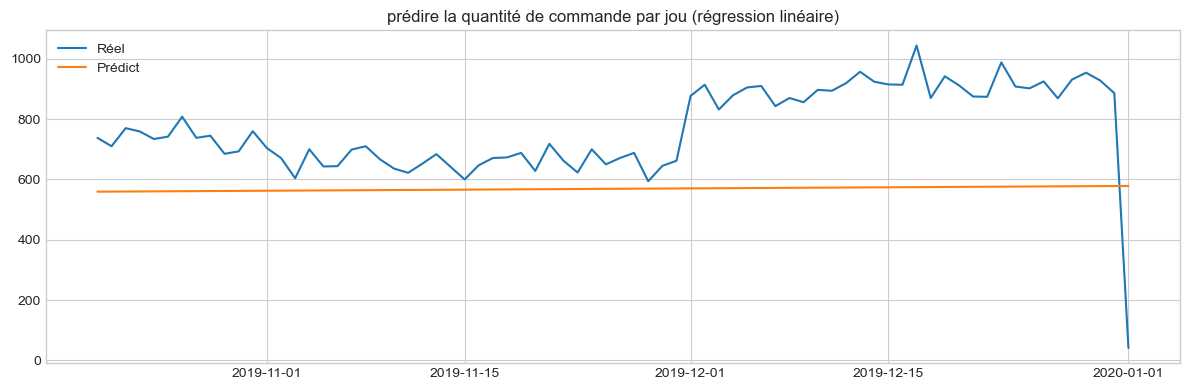

In [86]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
dates_test = quotidien['Jour'].iloc[-len(y_test):]
plt.plot(dates_test, y_test, label='Réel')
plt.plot(dates_test, y_pred, label='Prédict')
plt.title("prédire la quantité de commande par jou (régression linéaire)")
plt.legend()
plt.tight_layout()
plt.show()


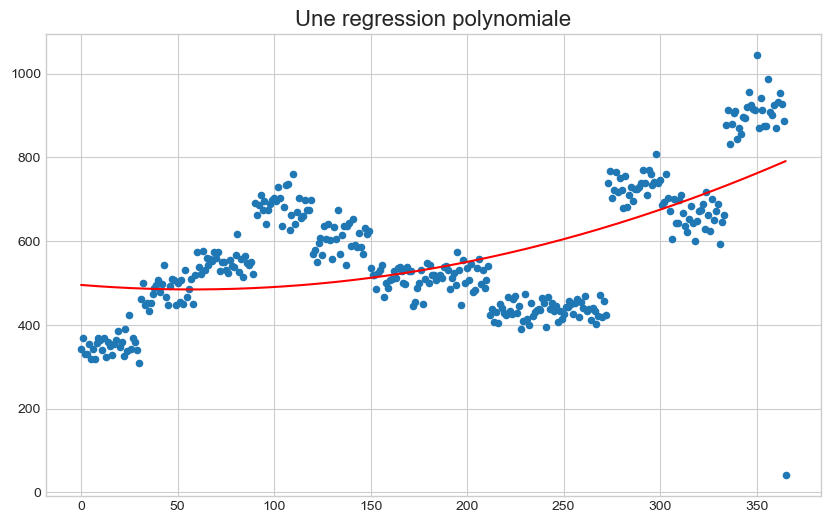

In [84]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

x = quotidien['j'].values.reshape(-1, 1)
y = quotidien['y'].values.reshape(-1, 1)

poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly_features.fit_transform(x)

reg = LinearRegression()
reg.fit(x_poly, y)

x_vals = np.linspace(x.min(), x.max(), 500).reshape(-1, 1)
x_vals_poly = poly_features.transform(x_vals)
y_vals = reg.predict(x_vals_poly)

plt.figure(figsize=(10,6))
plt.title("Une regression polynomiale", size=16)
plt.scatter(x, y, s=20)
plt.plot(x_vals, y_vals, c="red")
plt.show()
